# YOLO (You Only Look Once) Implementation for Traffic Assesment

## Prerequisites

#### Installing python dependencies

In [1]:
!pip install pillow

You should consider upgrading via the 'pip install --upgrade pip' command.


#### Importing libraries

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image
import matplotlib.patches as patches
import PIL
from PIL import Image
from xml.dom import minidom
import os
import random

tf.__version__

'2.1.0-dev20191011'

#### Listing availabel training devices

In [3]:
from tensorflow.python.client import device_lib
[x.name for x in device_lib.list_local_devices()]

['/device:CPU:0', '/device:XLA_CPU:0', '/device:XLA_GPU:0', '/device:GPU:0']

## Loading training/validation datasets

#### Defining images with which labels to be loaded

In [4]:
labels_to_load = {
    0: 'bicycle',
    1: 'bus',
    2: 'car',
    3: 'horse',
    4: 'motorbike',
    5: 'person',
    6: 'train'
}

#### Hyperparameters

In [5]:
RES = 448               # Image resolution
S = 7                   # Image square devisions
B = 2                   # Amount of bboxes to predict
C = len(labels_to_load) # Amount of class
S, B, C

(7, 2, 7)

#### Defining a class for the annotated image data

In [6]:
class AnnotatedImage:
    def __init__(self, name):
        self.name = name
        self.filepath = './data/VOCdevkit/VOC2012/JPEGImages/' + name + '.jpg'
        self.image = Image.open(self.filepath)
        self.objects = self.__parse_objects()

    def __parse_objects(self):
        def __parse_object_coords(self, xmin, ymin, xmax, ymax):
            return {'x': (xmax + xmin)/2, 'y': (ymax + ymin)/2, 'w': xmax - xmin, 'h': ymax - ymin}

        document = minidom.parse('./data/VOCdevkit/VOC2012/Annotations/' + self.name + '.xml')
        xml_objects = document.getElementsByTagName('object')
        parsed_objects = []
        
        for xml_object in xml_objects:
            xml_bbox = xml_object.getElementsByTagName('bndbox')[0]
            xmin = int(int(xml_bbox.getElementsByTagName('xmin')[0].firstChild.nodeValue)*(RES/self.image.size[0]))
            ymin = int(int(xml_bbox.getElementsByTagName('ymin')[0].firstChild.nodeValue)*(RES/self.image.size[1]))
            xmax = int(int(xml_bbox.getElementsByTagName('xmax')[0].firstChild.nodeValue)*(RES/self.image.size[0]))
            ymax = int(int(xml_bbox.getElementsByTagName('ymax')[0].firstChild.nodeValue)*(RES/self.image.size[1]))

            parsed_objects.append({
                'name': xml_object.getElementsByTagName('name')[0].firstChild.nodeValue,
                'bbox': __parse_object_coords(self, xmin, ymin, xmax, ymax),
                'bbox_alt': {'xmin': xmin, 'ymin': ymin, 'xmax': xmax, 'ymax': ymax}
            })

        return parsed_objects

#### Getting a list of all the train/val images of cars

In [19]:
# Loading all the filepaths in a list
train_images_to_load = []
val_images_to_load = []

for label in range(0, len(labels_to_load)):
    train_file = open('./data/VOCdevkit/VOC2012/ImageSets/Main/' + labels_to_load[label] + "_train.txt", 'r')
    val_file = open('./data/VOCdevkit/VOC2012/ImageSets/Main/' + labels_to_load[label] + "_val.txt", 'r')
    for line in train_file:
        train_images_to_load.append(line[:-4])
    for line in val_file:
        val_images_to_load.append(line[:-4])
    
# Removing duplicate filepaths
train_images_to_load = list(dict.fromkeys(train_images_to_load))
val_images_to_load = list(dict.fromkeys(val_images_to_load))

'Number of images to be loaded: train - {}, val - {}'.format(len(train_images_to_load), len(val_images_to_load))

'Number of images to be loaded: train - 5717, val - 5823'

#### Loading the train/val images into separate array

In [20]:
train_image_list = []
val_image_list = []

for filename in train_images_to_load:
    train_image_list.append(AnnotatedImage(filename))
    
for filename in val_images_to_load:
    val_image_list.append(AnnotatedImage(filename))

#### Removing labels which are not going to be used

In [21]:
for image in train_image_list:
    image.objects = list(filter(lambda x : not(x['name'] not in labels_to_load.values()), image.objects))
    
for image in val_image_list:
    image.objects = list(filter(lambda x : not(x['name'] not in labels_to_load.values()), image.objects))

#### Resizing the images for a consistent model input shape

In [22]:
for image in train_image_list:
    image.image = np.array(image.image.resize((RES, RES), Image.ANTIALIAS), dtype=np.uint8)

for image in val_image_list:
    image.image = np.array(image.image.resize((RES, RES), Image.ANTIALIAS), dtype=np.uint8)

#### Testing whether the images & objects are loaded properly

./data/VOCdevkit/VOC2012/JPEGImages/2011_000233.jpg
(448, 448, 3)
[{'name': 'motorbike', 'bbox': {'x': 241.0, 'y': 319.5, 'w': 206, 'h': 153}, 'bbox_alt': {'xmin': 138, 'ymin': 243, 'xmax': 344, 'ymax': 396}}]


<Figure size 432x288 with 0 Axes>

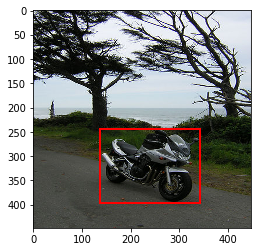

./data/VOCdevkit/VOC2012/JPEGImages/2008_000238.jpg
(448, 448, 3)
[{'name': 'bus', 'bbox': {'x': 214.5, 'y': 274.0, 'w': 429, 'h': 348}, 'bbox_alt': {'xmin': 0, 'ymin': 100, 'xmax': 429, 'ymax': 448}}]


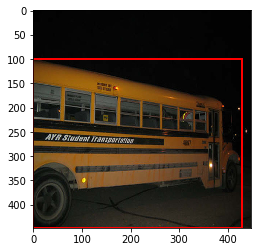

./data/VOCdevkit/VOC2012/JPEGImages/2008_004899.jpg
(448, 448, 3)
[{'name': 'car', 'bbox': {'x': 294.5, 'y': 371.0, 'w': 99, 'h': 40}, 'bbox_alt': {'xmin': 245, 'ymin': 351, 'xmax': 344, 'ymax': 391}}, {'name': 'car', 'bbox': {'x': 324.5, 'y': 365.5, 'w': 57, 'h': 31}, 'bbox_alt': {'xmin': 296, 'ymin': 350, 'xmax': 353, 'ymax': 381}}, {'name': 'person', 'bbox': {'x': 273.5, 'y': 399.0, 'w': 13, 'h': 46}, 'bbox_alt': {'xmin': 267, 'ymin': 376, 'xmax': 280, 'ymax': 422}}]


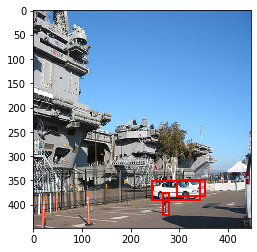

./data/VOCdevkit/VOC2012/JPEGImages/2011_000290.jpg
(448, 448, 3)
[{'name': 'person', 'bbox': {'x': 229.5, 'y': 271.0, 'w': 113, 'h': 78}, 'bbox_alt': {'xmin': 173, 'ymin': 232, 'xmax': 286, 'ymax': 310}}, {'name': 'person', 'bbox': {'x': 96.5, 'y': 408.5, 'w': 189, 'h': 79}, 'bbox_alt': {'xmin': 2, 'ymin': 369, 'xmax': 191, 'ymax': 448}}]


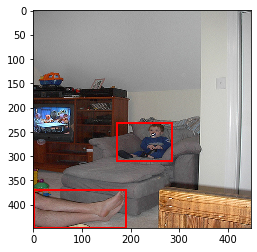

./data/VOCdevkit/VOC2012/JPEGImages/2009_000218.jpg
(448, 448, 3)
[]


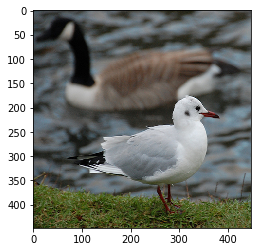

In [23]:
plt.figure()
for i in range(0, 5):
    rng = random.randint(1, len(train_image_list))
    fig, ax = plt.subplots(1)
    ax.imshow(train_image_list[rng].image)
    
    for object in train_image_list[rng].objects:
        rect = patches.Rectangle(
            (object['bbox_alt']['xmin'], object['bbox_alt']['ymin']),
            object['bbox_alt']['xmax'] - object['bbox_alt']['xmin'],
            object['bbox_alt']['ymax'] - object['bbox_alt']['ymin'],
            linewidth=2,
            edgecolor='#ff0000',
            facecolor='none'
        )
        ax.add_patch(rect)
        
    print(train_image_list[rng].filepath)
    print(train_image_list[rng].image.shape)
    print(train_image_list[rng].objects)
    plt.show()

## Defining and training the neural network

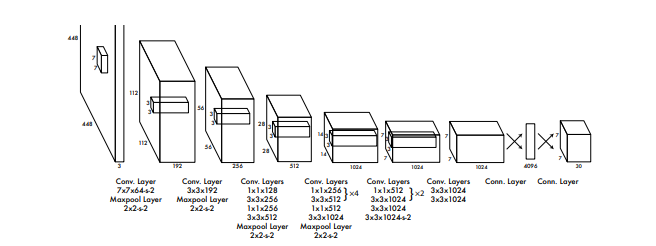

In [12]:
model = models.Sequential([
    layers.Conv2D(64, (S, S), strides=2, padding='same', activation='relu', input_shape=(448, 448, 3)),
    layers.MaxPooling2D((2, 2), input_shape=(224, 224, 64)),
    layers.Conv2D(192, (3, 3), strides=1, padding='same', activation='relu', input_shape=(112, 112, 64)),
    layers.MaxPooling2D((2, 2), input_shape=(112, 112, 192)),
    layers.Conv2D(128, (1, 1), strides=1, padding='same', activation='relu', input_shape=(56, 56, 192)),
    layers.Conv2D(256, (3, 3), strides=1, padding='same', activation='relu', input_shape=(56, 56, 128)),
    layers.Conv2D(256, (1, 1), strides=1, padding='same', activation='relu', input_shape=(56, 56, 256)),
    layers.Conv2D(512, (1, 1), strides=1, padding='same', activation='relu', input_shape=(56, 56, 512)),
    layers.MaxPooling2D((2, 2), input_shape=(56, 56, 512)),
    layers.Conv2D(256, (1, 1), strides=1, padding='same', activation='relu', input_shape=(28, 28, 512)),
    layers.Conv2D(512, (3, 3), strides=1, padding='same', activation='relu', input_shape=(28, 28, 256)),
    layers.Conv2D(256, (1, 1), strides=1, padding='same', activation='relu', input_shape=(28, 28, 512)),
    layers.Conv2D(512, (3, 3), strides=1, padding='same', activation='relu', input_shape=(28, 28, 256)),
    layers.Conv2D(256, (1, 1), strides=1, padding='same', activation='relu', input_shape=(28, 28, 512)),
    layers.Conv2D(512, (3, 3), strides=1, padding='same', activation='relu', input_shape=(28, 28, 256)),
    layers.Conv2D(256, (1, 1), strides=1, padding='same', activation='relu', input_shape=(28, 28, 512)),
    layers.Conv2D(512, (3, 3), strides=1, padding='same', activation='relu', input_shape=(28, 28, 256)),
    layers.Conv2D(512, (1, 1), strides=1, padding='same', activation='relu', input_shape=(28, 28, 512)),
    layers.Conv2D(1024, (3, 3), strides=1, padding='same', activation='relu', input_shape=(28, 28, 512)),
    layers.MaxPooling2D((2, 2), strides=2, padding='same', input_shape=(28, 28, 1024)),
    layers.Conv2D(512, (1, 1), strides=1, padding='same', activation='relu', input_shape=(14, 14, 1024)),
    layers.Conv2D(1024, (3, 3), strides=1, padding='same', activation='relu', input_shape=(14, 14, 512)),
    layers.Conv2D(512, (1, 1), strides=1, padding='same', activation='relu', input_shape=(14, 14, 1024)),
    layers.Conv2D(1024, (3, 3), strides=1, padding='same', activation='relu', input_shape=(14, 14, 512)),
    layers.Conv2D(1024, (3, 3), strides=1, padding='same', activation='relu', input_shape=(14, 14, 1024)),
    layers.Conv2D(1024, (3, 3), strides=2, padding='same', activation='relu', input_shape=(14, 14, 1024)),
    layers.Conv2D(1024, (3, 3), strides=1, padding='same', activation='relu', input_shape=(7, 7, 1024)),
    layers.Conv2D(1024, (3, 3), strides=1, padding='same', activation='relu', input_shape=(7, 7, 1024)),
    layers.Conv2D(1024, (3, 3), strides=1, padding='same', activation='relu', input_shape=(7, 7, 1024)),
    layers.Flatten(input_shape=(7, 7, 1024)),
    layers.Dense(4096, activation='relu', input_shape=(50176, )),
    layers.Dense(S * S * (B * 5 + C), activation='relu', input_shape=(4096, )),
    layers.Reshape((S, S, B * 5 + C), input_shape=(S * S * (B * 5 + C), ))
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      9472      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 192)     110784    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 192)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 128)       24704     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 256)       295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 56, 256)       6

In [13]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [14]:
checkpoint_path = "train_checkpont/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

p_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [15]:
history = model.fit(
    train_images, train_labels, epochs=10, 
    validation_data=(test_images, test_labels)
)

NameError: name 'train_images' is not defined